<a href="https://colab.research.google.com/github/shahoodzee/NER-for-biomedical-text/blob/main/NLP_Project_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installling Necessary Depedencies
!pip install transformers
!pip install -q simpletransformers
!pip install optuna

# GPU Runtime
If you're running this notebook in Google Colab, select Runtime > Change Runtime Type from the menubar. Ensure that GPU is selected as the Hardware accelerator. This will allow us to use the GPU to train the model subsequently.

###Required Libraries

Following Libraries are used in the NER Project.

In [ ]:
# Required Libraries

import urllib.request
from pathlib import Path
import pandas as pd
from simpletransformers.ner import NERModel
from transformers import AutoTokenizer
import pandas as pd
import logging
import optuna
from sklearn.metrics import f1_score

In [ ]:
#@title Data Extraction From BC5CDR

def download_file(url, output_file):
  Path(output_file).parent.mkdir(parents=True, exist_ok=True)
  urllib.request.urlretrieve (url, output_file)

download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/train.txt', '/content/data/train.txt')
download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/test.txt', '/content/data/test.txt')
download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/dev.txt', '/content/data/dev.txt') 

#Data Preparation

In [ ]:
#@title Convert data into Pandas format
def read_conll(filename):
    df = pd.read_csv(filename,
                    sep = '\t', header = None, keep_default_na = False,
                    names = ['words', 'pos', 'chunk', 'labels'],
                    quoting = 3, skip_blank_lines = False)
    df = df[~df['words'].astype(str).str.startswith('-DOCSTART- ')]
    df['sentence_id'] = (df.words == '').cumsum()
    return df[df.words != '']

In [ ]:
train_df = read_conll('/content/data/train.txt')
test_df = read_conll('/content/data/test.txt')
dev_df = read_conll('/content/data/dev.txt')


In [ ]:
train_df

,words,pos,chunk,labels,sentence_id
2,Naloxone,PROPN,O,I-Entity,1
3,reverses,VERB,O,O,1
4,the,DET,O,O,1
5,antihypertensive,ADJ,O,O,1
6,effect,NOUN,O,O,1
...,...,...,...,...,...
100805,and,CCONJ,O,O,4940
100806,home,NOUN,O,O,4940
100807,cage,NOUN,O,O,4940
100808,environments,NOUN,O,O,4940


In [ ]:
test_df

,words,pos,chunk,labels,sentence_id
2,Famotidine,PROPN,O,I-Entity,1
3,-,PUNCT,O,O,1
4,associated,VERB,O,O,1
5,delirium,NOUN,O,I-Entity,1
6,.,PUNCT,O,O,1
...,...,...,...,...,...
104323,glucose,NOUN,O,B-Entity,5137
104324,hypometabolism,NOUN,O,I-Entity,5137
104325,in,ADP,O,O,5137
104326,AD,NOUN,O,I-Entity,5137


#Reasing for Selecting BC5CDR

In [ ]:
#@title BC5CDR Contents
data = [[train_df['sentence_id'].nunique(), test_df['sentence_id'].nunique(), dev_df['sentence_id'].nunique()]]

# Prints out the dataset sizes of train and test sets per label.
pd.DataFrame(data, columns=["Train", "Test", "Dev"])

,Train,Test,Dev
0,3942,4139,3949


#### Task Description

> Named entity recognition (NER) is the task of tagging entities in text with their corresponding type. Approaches typically use BIO notation, which differentiates the beginning (B) and the inside (I) of entities. O is used for non-entity tokens.

In [ ]:
#@title Training Arguments

train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': True,
    'max_seq_length': 64,
    'num_train_epochs': 10,
    'train_batch_size': 32,
    'fp16': True,
    'output_dir': '/outputs/',
    'best_model_dir': '/outputs/best_model/',
    'evaluate_during_training': True,
}


In [ ]:
mylabels = list()
mylabels.append('I-Entity')
mylabels.append('O')
mylabels.append('B-Entity')
mylabels

['I-Entity', 'O', 'B-Entity']

# Training Arguments
We set up the training arguments. Here we train to 10 epochs to get accuracy close to the SOTA. The train, test and dev sets are relatively small so we don't have to wait too long. We set a sliding window as NER sequences can be quite long and because we have limited GPU memory we can't increase the max_seq_length too long.

In [ ]:
#@title Training the Model
logging.basicConfig(level=logging.DEBUG)
transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

# We use the bio BERT pre-trained model.
model = NERModel('bert', 'dmis-lab/biobert-v1.1', labels=mylabels, args=train_args)

# Train the model
# https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model.train_model(train_df, eval_data=dev_df)

# Evaluate the model in terms of accuracy score
result, model_outputs, preds_list = model.eval_model(test_df)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/518 [00:00<?, ?it/s]

##Evaluations


In [ ]:
result

{'eval_loss': 0.15510845884653246,
 'precision': 0.8849070323049756,
 'recall': 0.9050249654732816,
 'f1_score': 0.8948529411764706}

##SOTA Rankings

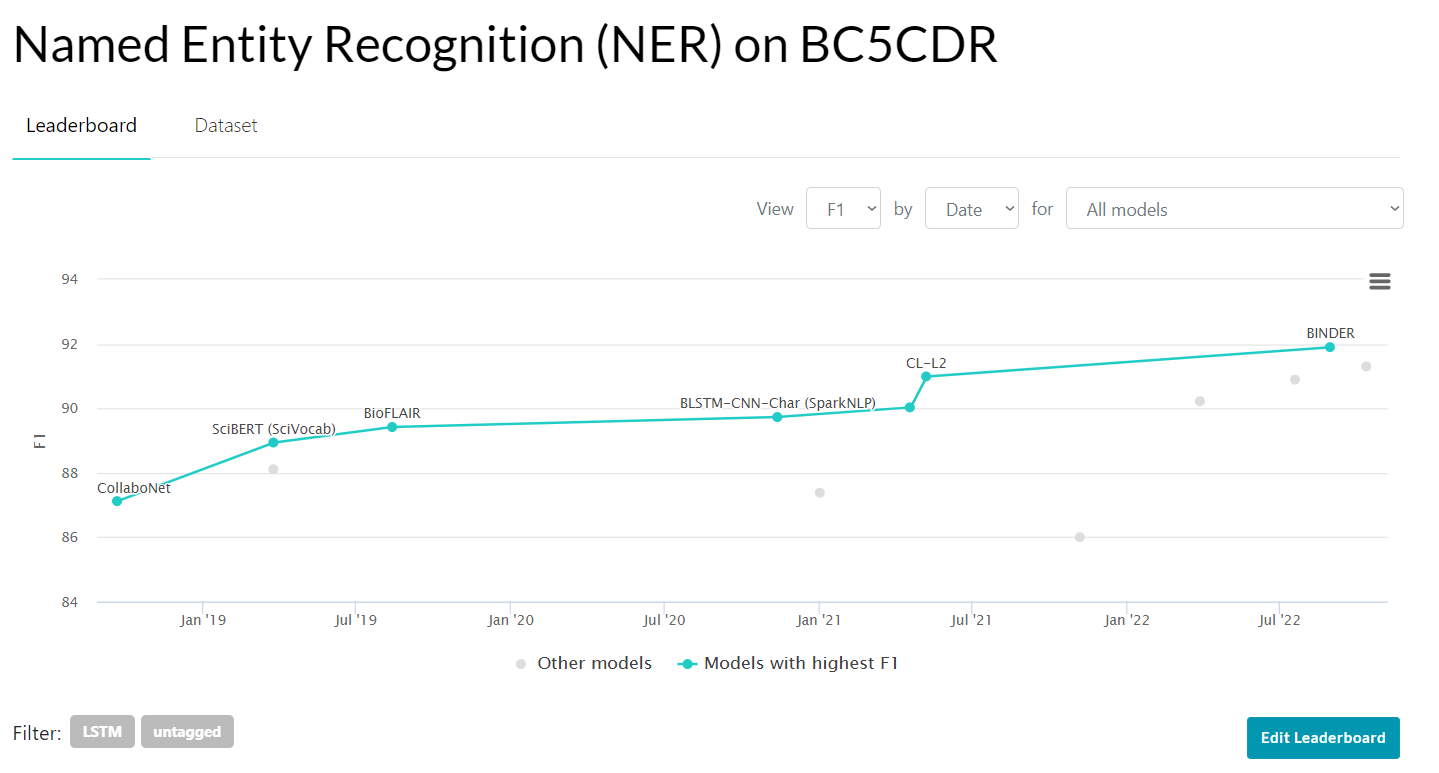

In [ ]:
#@title Testing a Sample on our Trained Model.
sample = test_df[test_df.sentence_id == 10].words.str.cat(sep=' ')
print(sample)

After a single oral dose of 4 mg / kg indomethacin ( IDM ) to sodium and volume depleted rats plasma renin activity ( PRA ) and systolic blood pressure fell significantly within four hours .


In [ ]:
samples = [sample]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'After': 'O'}
{'a': 'O'}
{'single': 'O'}
{'oral': 'O'}
{'dose': 'O'}
{'of': 'O'}
{'4': 'O'}
{'mg': 'O'}
{'/': 'O'}
{'kg': 'O'}
{'indomethacin': 'I-Entity'}
{'(': 'O'}
{'IDM': 'I-Entity'}
{')': 'O'}
{'to': 'O'}
{'sodium': 'I-Entity'}
{'and': 'O'}
{'volume': 'O'}
{'depleted': 'O'}
{'rats': 'O'}
{'plasma': 'O'}
{'renin': 'O'}
{'activity': 'O'}
{'(': 'O'}
{'PRA': 'O'}
{')': 'O'}
{'and': 'O'}
{'systolic': 'O'}
{'blood': 'O'}
{'pressure': 'O'}
{'fell': 'O'}
{'significantly': 'O'}
{'within': 'O'}
{'four': 'O'}
{'hours': 'O'}
{'.': 'O'}


In [ ]:
# import optuna
# from sklearn.metrics import f1_score

# # Define the objective function for Optuna to optimize
# def objective(trial):
#     train_args = {
#         'reprocess_input_data': True,
#         'overwrite_output_dir': True,
#         'sliding_window': True,
#         'max_seq_length': trial.suggest_int('max_seq_length', 64, 256),  # Adjust the range based on your needs
#         'num_train_epochs': trial.suggest_int('num_train_epochs', 5, 20),  # Adjust the range based on your needs
#         'train_batch_size': trial.suggest_categorical('train_batch_size', [16, 32, 64]),  # Adjust the values based on your needs
#         'fp16': trial.suggest_categorical('fp16', [True, False]),  # Adjust the values based on your needs
#         'output_dir': '/outputs/',
#         'best_model_dir': '/outputs/best_model/',
#         'evaluate_during_training': False,
#     }
    
#     # Train the model with the current hyperparameters
#     model = NERModel('bert', 'dmis-lab/biobert-v1.1', labels=mylabels, args=train_args)
#     model.train_model(train_df)
    
#     # Evaluate the model on the validation set
#     result, _, _ = model.eval_model(test_df, f1=f1_score)
    
#     # Return the F1 score as the objective value to optimize
#     return result['f1_score']

# # Set up your train_data and eval_data accordingly

# # Set up the Optuna optimization
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)  # Adjust the number of trials based on your computational resources

# # Print the best hyperparameter values and the corresponding F1 score
# best_trial = study.best_trial
# print("Best trial:")
# print(f"- F1 score: {best_trial.value:.4f}")
# print("- Hyperparameters:")
# for key, value in best_trial.params.items():
#     print(f"  {key}: {value}")
